In [2]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import models, transforms
from torchvision.models import ResNet18_Weights

# 1. Import data based on folders
Data is labelled and put into their respective class folders

In [6]:
def count_files_in_dir(dir_path):
    count = 0
    for path in os.listdir(dir_path):
        if os.path.isfile and not path.endswith('.DS_Store'):
            count += 1
    return count

for d in os.listdir("dataset/posture"):
    if os.path.isdir and d != '.DS_Store':
        file_count = count_files_in_dir(os.path.join("dataset/posture", d))
        print(f"Directory {d} has {file_count} files.")

Directory good_posture has 196 files.
Directory bad_posture has 204 files.


Create a custom dataset class

In [7]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
        self.files = [(f, c) for c in self.classes for f in os.listdir(os.path.join(root_dir, c)) if f.lower().endswith(('png', 'jpg', 'jpeg'))]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_name, label = self.files[idx]
        img_path = os.path.join(self.root_dir, label, img_name)
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        return image, self.classes.index(label)

Define Transformations

In [8]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

Define datasets and split it into training and testing

In [9]:
dataset = CustomDataset(root_dir='dataset/posture', transform=transform)
label_names = dataset.classes
print(label_names)

# Split the dataset into training and testing sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Check data loader 
data_iter = iter(train_loader)
images, labels = next(data_iter)
print(type(images), type(labels))
print(images.shape, labels.shape)
print("Labels: ", labels)

['good_posture', 'bad_posture']
<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([16, 3, 128, 128]) torch.Size([16])
Labels:  tensor([1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0])


# 2. Design the CNN

In [10]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(in_features=64*16*16, out_features=128)  # assuming the input image size is 128x128
        self.fc2 = nn.Linear(in_features=128, out_features=2)  # 2 classes

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, kernel_size=2, stride=2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, kernel_size=2, stride=2)
        x = torch.relu(self.conv3(x))
        x = torch.max_pool2d(x, kernel_size=2, stride=2)
        x = x.view(x.size(0), -1)  # flatten the tensor
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the model
model = CNN()
print(model)

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=16384, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)


# 3. Train the model 

First, check if GPU backend works

In [11]:
torch.backends.mps.is_available()

True

In [13]:
# define training hyperparameters
lr = 1e-3
num_epochs = 15

# set the device we will be using to train the model (to enable hardware acceleration)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu") # setting for mac
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
model.to(device)

for epoch in range(num_epochs):
    running_loss = 0.0  # Keep track of running loss
    correct_preds = 0   # Keep track of the number of correct predictions
    total_samples = 0   # Keep track of the total number of samples
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Update running loss
        running_loss += loss.item() * images.size(0)
        
        # Compute predicted labels
        _, predicted_labels = torch.max(outputs, 1)
        
        # Update number of correct predictions and total samples
        correct_preds += (predicted_labels == labels).sum().item()
        total_samples += labels.numel()
        
    # Compute average loss and accuracy for the epoch
    epoch_loss = running_loss / total_samples
    epoch_accuracy = correct_preds / total_samples
    
    # Print average loss and accuracy for the epoch
    print(f'Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss:.4f} - Accuracy: {epoch_accuracy:.4f}')

Epoch [1/15] - Loss: 0.0129 - Accuracy: 0.9938
Epoch [2/15] - Loss: 0.0150 - Accuracy: 0.9938
Epoch [3/15] - Loss: 0.0010 - Accuracy: 1.0000
Epoch [4/15] - Loss: 0.0001 - Accuracy: 1.0000
Epoch [5/15] - Loss: 0.0001 - Accuracy: 1.0000
Epoch [6/15] - Loss: 0.0000 - Accuracy: 1.0000
Epoch [7/15] - Loss: 0.0000 - Accuracy: 1.0000
Epoch [8/15] - Loss: 0.0000 - Accuracy: 1.0000
Epoch [9/15] - Loss: 0.0000 - Accuracy: 1.0000
Epoch [10/15] - Loss: 0.0000 - Accuracy: 1.0000
Epoch [11/15] - Loss: 0.0000 - Accuracy: 1.0000
Epoch [12/15] - Loss: 0.0000 - Accuracy: 1.0000
Epoch [13/15] - Loss: 0.0000 - Accuracy: 1.0000
Epoch [14/15] - Loss: 0.0000 - Accuracy: 1.0000
Epoch [15/15] - Loss: 0.0000 - Accuracy: 1.0000


# 4. Evaluate the model

Classification Report:
              precision    recall  f1-score   support

good_posture       0.97      1.00      0.99        34
 bad_posture       1.00      0.98      0.99        46

    accuracy                           0.99        80
   macro avg       0.99      0.99      0.99        80
weighted avg       0.99      0.99      0.99        80



Text(0.5, 1.0, 'Confusion Matrix')

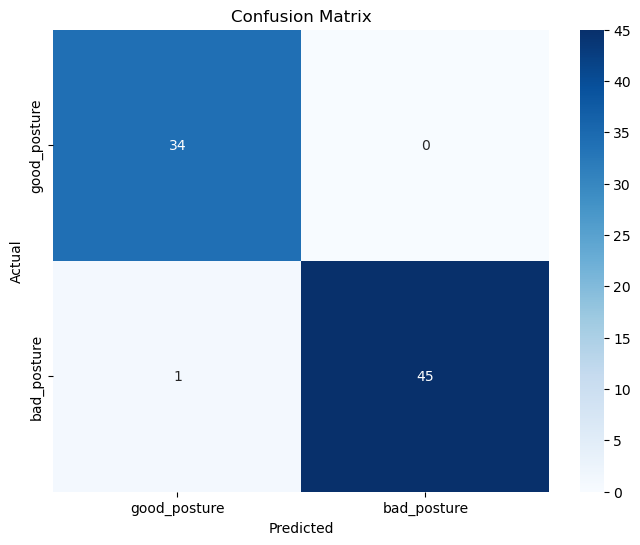

In [14]:
# Ensure the model is in evaluation mode
model.eval()

# Collect all labels and predictions
all_labels = []
all_preds = []

# Disable gradient computation (as it's not needed for evaluation and saves memory)
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_labels.append(labels)
        all_preds.append(preds)

# Concatenate all the labels and predictions
all_labels = torch.cat(all_labels)
all_preds = torch.cat(all_preds)

# Compute the confusion matrix and classification report
cm = confusion_matrix(all_labels.cpu().numpy(), all_preds.cpu().numpy())
report = classification_report(all_labels.cpu().numpy(), all_preds.cpu().numpy(), target_names=dataset.classes)

# Print the confusion matrix and classification report
# print("Confusion Matrix:")
# print(cm)
print("Classification Report:")
print(report)

# 4. Display the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=dataset.classes,
            yticklabels=dataset.classes)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')

## Use Transfer Learning

In [15]:
model_trf = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

# Modify final layers to match data
num_ftrs = model_trf.fc.in_features
model_trf.fc = nn.Linear(num_ftrs, 2)  # Assuming 2 classes in your dataset

print(model_trf)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Train Model
First, gotta test if GPU is working

In [16]:
torch.backends.mps.is_available()

True

In [17]:
# define training hyperparameters
lr = 1e-3
num_epochs = 15

# set the device we will be using to train the model (to enable hardware acceleration)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu") # setting for mac
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_trf.parameters(), lr=lr)
model_trf.to(device)

for epoch in range(num_epochs):
    running_loss = 0.0  # Keep track of running loss
    correct_preds = 0   # Keep track of the number of correct predictions
    total_samples = 0   # Keep track of the total number of samples
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model_trf(images)
        loss = criterion(outputs, labels)
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Update running loss
        running_loss += loss.item() * images.size(0)
        
        # Compute predicted labels
        _, predicted_labels = torch.max(outputs, 1)
        
        # Update number of correct predictions and total samples
        correct_preds += (predicted_labels == labels).sum().item()
        total_samples += labels.numel()
        
    # Compute average loss and accuracy for the epoch
    epoch_loss = running_loss / total_samples
    epoch_accuracy = correct_preds / total_samples
    
    # Print average loss and accuracy for the epoch
    print(f'Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss:.4f} - Accuracy: {epoch_accuracy:.4f}')

Epoch [1/15] - Loss: 0.4496 - Accuracy: 0.8469
Epoch [2/15] - Loss: 0.1634 - Accuracy: 0.9094
Epoch [3/15] - Loss: 0.2733 - Accuracy: 0.9125
Epoch [4/15] - Loss: 0.1225 - Accuracy: 0.9563
Epoch [5/15] - Loss: 0.0806 - Accuracy: 0.9750
Epoch [6/15] - Loss: 0.0556 - Accuracy: 0.9844
Epoch [7/15] - Loss: 0.0364 - Accuracy: 0.9844
Epoch [8/15] - Loss: 0.0444 - Accuracy: 0.9875
Epoch [9/15] - Loss: 0.0047 - Accuracy: 1.0000
Epoch [10/15] - Loss: 0.0015 - Accuracy: 1.0000
Epoch [11/15] - Loss: 0.0008 - Accuracy: 1.0000
Epoch [12/15] - Loss: 0.0005 - Accuracy: 1.0000
Epoch [13/15] - Loss: 0.0004 - Accuracy: 1.0000
Epoch [14/15] - Loss: 0.0003 - Accuracy: 1.0000
Epoch [15/15] - Loss: 0.0003 - Accuracy: 1.0000


## Evaluate model

Classification Report:
              precision    recall  f1-score   support

good_posture       0.97      1.00      0.99        34
 bad_posture       1.00      0.98      0.99        46

    accuracy                           0.99        80
   macro avg       0.99      0.99      0.99        80
weighted avg       0.99      0.99      0.99        80



Text(0.5, 1.0, 'Confusion Matrix')

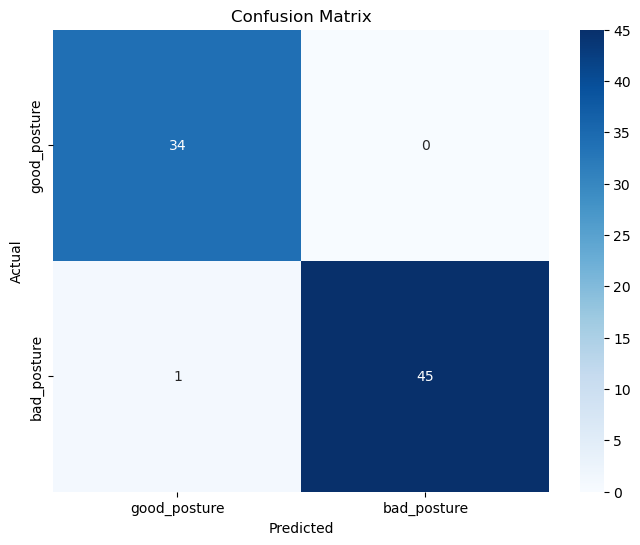

In [18]:
# Ensure the model is in evaluation mode
model_trf.eval()

# Collect all labels and predictions
all_labels = []
all_preds = []

# Disable gradient computation (as it's not needed for evaluation and saves memory)
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_trf(images)
        _, preds = torch.max(outputs, 1)
        all_labels.append(labels)
        all_preds.append(preds)

# Concatenate all the labels and predictions
all_labels = torch.cat(all_labels)
all_preds = torch.cat(all_preds)

# Compute the confusion matrix and classification report
cm = confusion_matrix(all_labels.cpu().numpy(), all_preds.cpu().numpy())
report = classification_report(all_labels.cpu().numpy(), all_preds.cpu().numpy(), target_names=dataset.classes)

# Print the confusion matrix and classification report
# print("Confusion Matrix:")
# print(cm)
print("Classification Report:")
print(report)

# 4. Display the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=dataset.classes,
            yticklabels=dataset.classes)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')